# LINEAR REGRESSION - ASSUMPTIONS AND INTERPRETATIONS

by Sebastian T. Glavind, December, 2020

In [1]:
import numpy as np
import math
import scipy.stats as ss
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.model_selection
import statsmodels.api as sm
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

# The model

In the simplest case of linear regression, sometimes called ordinary linear regression, the scalar output $y$ is assumed to be a linear combination of the inputs $\mathbf{x}$, and the observation errors follow a Gaussian white noise distribution, thus

$$ y | \mathbf{w}, \sigma, \mathbf{x} \sim \mathcal{N}(w_0 + \sum_{m=1}^{M-1} w_m x_m, \sigma^2) = \mathcal{N}(\mathbf{w}^T \mathbf{x}, \sigma^2), $$

where we have augmented the input vector $\mathbf{x}$ with an additional first element, which is always 1, thus $\mathbf{x} = (1, x_1, x_2, ..., x_{M-1})$.

If we now consider a training data set $\mathcal{D}=\{ \mathbf{x}[n], y[n] \}_{n=1}^N = \{ \mathbf{X}, \mathbf{y} \}$, where $\mathbf{X}$ is a $ N \times M $ design matrix and $\mathbf{y}$ is a column vector of the corresponding output observations, the joint likelihood of the training data may be written:

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \prod_{n=1}^N \mathcal{N}(\mathbf{w}^T \mathbf{x}[n], \sigma^2) = \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identity matrix. See e.g. Wasserman (2004) for further details on linear regression.

***
Wasserman, L. (2004). All of statistics: a concise course in statistical inference. Springer Science & Business Media.
***

# Sample data

We start by generating a data set, which we will study in the remainder of this tutorial. In this regard, we will use functionalities from the library ``scikit-learn`` to generate a toy example with five input variables and one output variable. The inputs generated are independent, standard normal and appear in an input matrix below. This matrix is later converted to a design matrix, by including a vector of ones, to account for a potential bias in the output. The model outputs and true coefficients appear as vectors below.

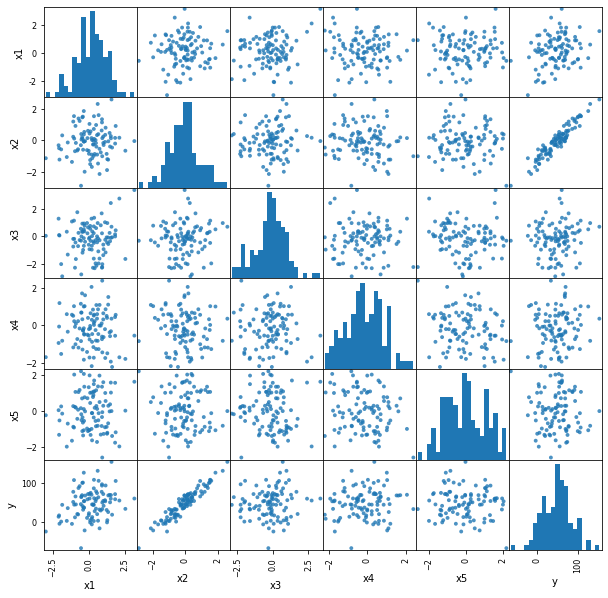

In [2]:
# generate data (matrix of inputs, vector of outputs and true underlaying coefficients)
nX = 200
mX, mXinf = 5, 3
std_y = 5
bias_y = 50
X, y, coef = sklearn.datasets.make_regression(n_samples=nX, n_features=5, n_informative=3, n_targets=1, # note that only 3 inputs are informative!
                                        bias=bias_y, noise=std_y, shuffle=True, coef=True, random_state=100)
y = y.reshape(-1,1)
coef = np.hstack([bias_y, coef])

# Split data into training and test
Xtr, Xte, ytr, yte = sklearn.model_selection.train_test_split(X, y, train_size=.5, shuffle=True, random_state=42)
nXtr, mXtr = Xtr.shape
nXte, mXte = Xte.shape

# plotting
varNames = ['x1', 'x2', 'x3', 'x4', 'x5','y']
dfXy = pd.DataFrame(np.hstack((Xtr, ytr)), columns=varNames)
pd.plotting.scatter_matrix(dfXy, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

From the scatter matrix above, we see no apparent dependence among the inputs, and we observe a (linear) relationship between the output and input $x_1$, $x_2$ and $x_4$, respectively. There is no apparent relationship between the output and the remaining outputs.   

# Ordinary least squares solution

See my tutorial on [*Linear regression*](https://nbviewer.jupyter.org/github/SebastianGlavind/PhD-study/blob/master/Linear-regression/LinReg.ipynb) for the mathematical details on how to conduct inference in this setting.

Note that the least squares solution has the following properties

$$ E[\mathbf{w}] = E[(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}] = E[ (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T (\mathbf{X}\mathbf{w} + \epsilon)] ] = \mathbf{w}$$

$$ Var[\mathbf{w}] = Var[(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}] = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Var[Y] \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \sigma^2 \mathbf{I} \ \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} = \sigma^2 (\mathbf{X}^T \mathbf{X})^{-1}.$$

Thus, it is unbiased with a closed form solution for the covariance, see e.g. Wasserman (2004). Under the assumption of normality of the noise precess $\epsilon$ ($\mathbf{X}$ is fixed), it follows that $\mathbf{w}$ also follow a Gaussian distribution with mean $E[\mathbf{w}]$ and covariance $Var[\mathbf{w}]$, as written above.

In [3]:
def myOLS(XX,y):
    nX, mX = XX.shape; 
    Wols = np.linalg.pinv(XX).dot(y);
    mu_ols = np.dot(XX, Wols)
    SSE_ols = np.sum( (y - mu_ols)**2) 
    sigma_ols_unbias = np.sqrt(SSE_ols / (nX-mX))
    Rsq = 1 - SSE_ols / np.sum( (y-np.mean(y))**2 ) 
    return(Wols, sigma_ols_unbias, Rsq)

def myMSE(XX, y, W):
    nX = XX.shape[0]; 
    yest = np.dot(XX, W)
    ydiff = y - yest
    mse = np.dot(ydiff.T, ydiff)/nX
    return(mse[0,0], ydiff)
    
XXtr = np.hstack([np.ones(nXtr).reshape(-1,1), Xtr])
XXte = np.hstack([np.ones(nXte).reshape(-1,1), Xte])
Wols, sigma_ols_unbias, Rsq = myOLS(XXtr,ytr)
covW = sigma_ols_unbias**2 * np.linalg.inv( np.dot(XXtr.T, XXtr) )
mse_te, ydiff_te = myMSE(XXte, yte, Wols)
print('Point estimate for OLS parameters: ', np.round(Wols.T,2)[0])
print('Standard error for OLS parameters: ', np.round(np.diag(covW),2) )
print('Unbiased estimate of output standard error: ', round(sigma_ols_unbias,2))
print('R-squared metric: ', np.round(Rsq,2))
print('MSE on test set: ', np.round(mse_te,2))

print('-------------------------------------------------------------------------------------')

print('True parameters: ', np.round(coef,2))
print('True standard deviation: ', round(std_y,2))

Point estimate for OLS parameters:  [49.89  7.17 36.02 -0.45  7.63 -0.08]
Standard error for OLS parameters:  [0.24 0.19 0.24 0.17 0.23 0.19]
Unbiased estimate of output standard error:  4.62
R-squared metric:  0.98
MSE on test set:  27.1
-------------------------------------------------------------------------------------
True parameters:  [50.    6.57 36.89  0.    7.9   0.  ]
True standard deviation:  5


The model fit is plotted against the training and test set below;

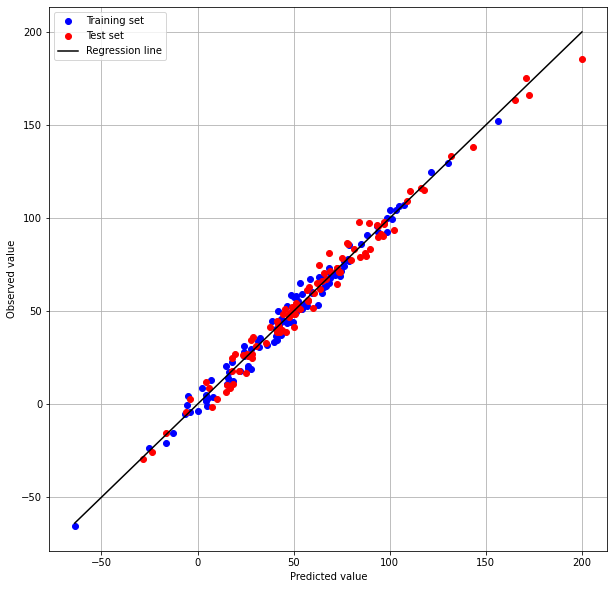

In [4]:
# redidual scatter plot
mu_pred_tr = np.dot(XXtr, Wols)
mu_pred_te = np.dot(XXte, Wols)

mu_pred = np.concatenate([mu_pred_tr, mu_pred_te])
x_plot_fit = y_plot_fit = np.array([np.min(mu_pred), np.max(mu_pred)])
plt.figure(figsize=(10,10))
plt.plot(mu_pred_tr, ytr, 'ob', label='Training set')
plt.plot(mu_pred_te, yte, 'or', label='Test set')
plt.plot(x_plot_fit, y_plot_fit, '-k', label='Regression line')
plt.xlabel('Predicted value')
plt.ylabel('Observed value')
plt.legend()
plt.grid()
plt.show()

Another common way of visualizing the regression is by plotting the regression on the individual inputs, where the remaining inputs are held constant at their mean value.

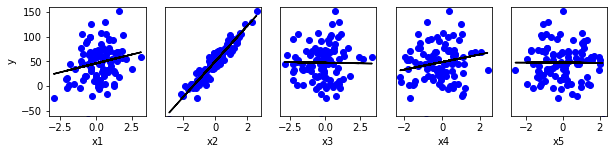

In [5]:
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    index_not_i = np.setdiff1d(np.arange(0,5,1), i+1)
    XXtr_fit_i = XXtr.copy();
    XXtr_fit_i[:,index_not_i] = np.mean(XXtr[:,index_not_i],0)
    x_plot_fit_i = XXtr_fit_i[:,i+1]
    mu_plot_fit_i = np.dot(XXtr_fit_i, Wols) # as mu of all x_i ~ 0, we could also simply have used f = Wols[0] + XXtr[:,i+1]*Wols[i+1] 
    plt.plot(x_plot_fit_i, ytr, 'ob', label='Training set')
    plt.plot(x_plot_fit_i, mu_plot_fit_i, '-k', label='Regression line')
    plt.xlabel('x'+str(i+1))
    if i==0:
        plt.ylabel('y')
    else:
        plt.yticks([])
#     plt.legend()
    plt.ylim([-60,160])


As apparent from the subplots above, we again observe a (linear) relationship between the output and input $x_1$, $x_2$ and $x_4$, respectively, and no apparent relationship between the output and the remaining outputs. This is in agreement with the insignificant regression coefficients found above for variable $x_3$ and $x_5$. 

# Assessment of the model assumptions

Following Gelman et al. (2020), the assumptions of linear regression are listed below in decreasing order of importance.

1. Validity
2. Representativeness
3. Additivity and linearity
4. Independence of errors
5. Equal variance of errors
6. Normality of errors

In the following, we will address these one by one, along with associated interpretations.

***
Gelman, A., Hill, J., & Vehtari, A. (2020). Regression and other stories. Cambridge University Press.
***

## Assumption 1: Validity

The fundamental assumption of linear regression, and modeling in general, is that the data being analyzed reflect the research question. This means that the outcome measure should reflect the phenomena under study, including all relevant predictors (inputs), such that the model can generalize to the cases for which it will be used for inference. As an example, a model of incomes will not necessarily tell us anything about patterns of total assets, see Gelman et al. (2020, ch.11). 

We will not dive further into this assumption, as the objective of this tutorial is the numerical assessment of the assumptions of linear regression, which we study on a toy example only for illustration purposes. 

## Assumption 2: Representativeness

This assumption addresses the fact that a regression model build from sample data is generally employed to make inferences about a larger population, i.e. we assume that the data is representative of the distribution of the output $y$ given inputs $\{x_i\}_{i=1}^M$, which are included in the modeling. As an example, in a general regression of earnings on sex and height, it would be acceptable for women and tall people to be overrepresented in the sample, compared to the general population, but it would be problematic if the sample include too many rich people $-$ selection on $x_i$ does not interfere with inference from the regression model, but selection on $y$ does! See Gelman et al. (2020, ch.11) 

Again, we will not dive further into this assumption, as it is outside the scope of this tutorial, but ...

### Multicollinearity

Both the validity and representativeness assumption points to the inclusion of more predictors in the regression, as (i) a regression should include all predictors of relevant in predicting the phenomena of interest, and (ii) it allows the representativeness, conditional on $\mathbf{X}$, to be more reasonable. Thus, choosing the inputs to a regression model is a crucial and challenging part of a regression analysis, and there are some pitfalls related to identifiability issues, which can make the model less interpretable. The most familiar and important case of non-identifiability is multicollinearity, see Gelman et al. (2020, ch.10-11)

Multicollinearity is a common problem when estimating linear and generalized linear models. It occurs when there are high correlations among input variables, leading to unreliable and unstable estimates of regression coefficients. This means that multicollinearity make it difficult to choose the correct predictors (inputs) to include in the model and interferes in determining the precise effect of each predictor, but it does not affect the overall fit of the model or the predictions! In the following, we will study these effects in turn.

#### The uncorrelated case (no multicollinearity)

Again, as apparent from the scatter matrix above (*Sample data* section) we observe no immediate dependence among the inputs in the training set of our tay example. This may be further assessed by studying the corresponding correlation matrix;

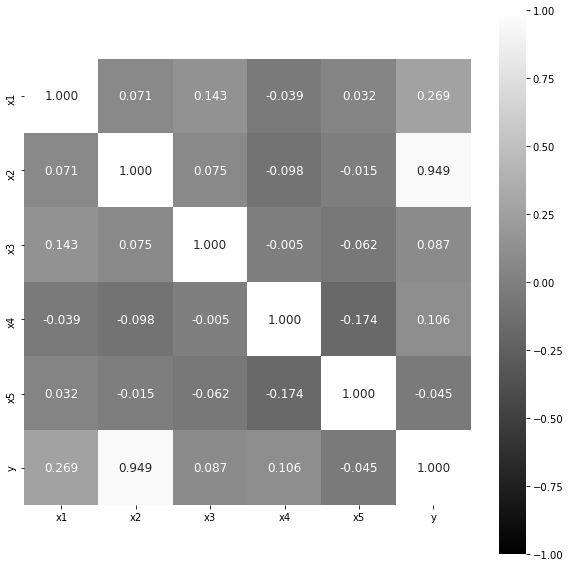

In [6]:
dfCorr=dfXy.corr() # correlation matrix

plt.figure(figsize = (10,10))
heatplt=sns.heatmap(dfCorr, annot=True, fmt=".3f", vmin=-1, vmax=1, cmap='gray', annot_kws={"size": 12},square=True);
cbar = heatplt.collections[0].colorbar
plt.show()

The correlation matrix tells as similar story as the scatter matrix, i.e. only week correlations exist among the inputs. Note that it is only the informative inputs, i.e. $x_1$, $x_2$ and $x_4$, which correlate significantly with the output. Thus, the correlation matrix also provides information on the impact of each input on the output.

A commonly used measure for assessing multicollinearity is the variance inflation factor (VIF), which is defined as 

$$ \text{VIF}(X_i) = (1- \{R^2|\mathbf{X}_{\sim i}\})^{-1}, $$

where $R^2$ is calculated for each input $X_i$ by performing a linear regression of that input on all the remaining inputs $\mathbf{X}_{\sim i}$. Note that the VIF may easily be found as the diagonal terms of the inverse correlation matrix for normalized inputs, see e.g.  [math.stackexchange.com](https://math.stackexchange.com/questions/2681911/prove-vif-of-jth-predictor-is-jth-diagonal-entry-of-inverse-of-correlation-matri).

VIFs range from 1 and upwards, where the numerical values indicate how much the variance of each coefficient is inflated. For example, a VIF of 1.9 indicates that the variance of that particular coefficient is 90% bigger than what you would expect if there was no multicollinearity, see e.g. [statisticshowto.com](https://www.statisticshowto.com/variance-inflation-factor/). As a rule of thumb, a VIF around 0 indicates no correlation, a VIF around 5 indicates moderate correlation, and a VIF around 10 indicates high correlation.

In [7]:
VIF = np.diag(np.linalg.inv(dfCorr.to_numpy(copy=True)[:5,:5]))
print('Variance inflation factors: ', np.round(VIF,3))

# Test
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# dfXX = dfXy.copy()
# dfXX = dfXX.drop('y', axis=1); # print(dfXX.head())
# dfXX = add_constant(dfXX); # print(dfXX.head())
# pd.Series([variance_inflation_factor(dfXX.values, i) for i in range(dfXX.shape[1])], index=dfXX.columns)

Variance inflation factors:  [1.027 1.02  1.03  1.043 1.038]


As expected, the VIFs take on values around 1, i.e. no variance inflation, and thus we conclude that multicollinearity is not a problem in this case.

#### The correlated case (multicollinearity)

We can easily convert our uncorrelated (multivariate) Gaussian sample to a correlated sample using the Cholesky decomposition as

$$ \mathbf{X}^{(C)} = \boldsymbol\mu + \mathbf{X}^{(I)} \mathbf{L}^T, $$

where the covariance matrix $\Sigma = \mathbf{L}\mathbf{L}^T$, $\mathbf{X}^{(I)}$ and $\mathbf{X}^{(C)}$ are a matrix containing the independent input variables and dependent input variables, respectively.

In [8]:
np.random.seed(1000)
cov = np.array([[1.        , 0.90595519, 0.67363845, 0.41111229, 0.20592425],
                [0.90595519, 1.        , 0.90595519, 0.67363845, 0.41111229],
                [0.67363845, 0.90595519, 1.        , 0.90595519, 0.67363845],
                [0.41111229, 0.67363845, 0.90595519, 1.        , 0.90595519],
                [0.20592425, 0.41111229, 0.67363845, 0.90595519, 1.        ]])
Lcl = np.linalg.cholesky(cov)
Xtr_c = np.dot(Xtr, Lcl.T) # zero mean
Xte_c = np.dot(Xte, Lcl.T) # zero mean
XXtr_c = np.hstack([np.ones(Xtr_c.shape[0]).reshape(-1,1), Xtr_c])
XXte_c = np.hstack([np.ones(Xte_c.shape[0]).reshape(-1,1), Xte_c])
ytr_c = np.dot(XXtr_c, coef).reshape(-1,1) + np.random.normal(loc=0, scale=std_y, size=nXtr).reshape(-1,1)
yte_c = np.dot(XXte_c, coef).reshape(-1,1) + np.random.normal(loc=0, scale=std_y, size=nXte).reshape(-1,1)

For this correlated sample, we first fit the model;

In [9]:
Wols_c, sigma_ols_unbias_c, Rsq_c = myOLS(XXtr_c,ytr_c)
covW_c = sigma_ols_unbias_c**2 * np.linalg.inv( np.dot(XXtr_c.T, XXtr_c) )
mse_te_c, _ = myMSE(XXte_c, yte_c, Wols_c)

print('Point estimate for OLS parameters: ', np.round(Wols_c.T,2)[0])
print('Standard error for OLS parameters: ', np.round(np.diag(covW_c),2) )
print('Unbiased estimate of output standard error: ', round(sigma_ols_unbias_c,2))
print('R-squared metric: ', round(Rsq_c,2))
print('MSE on test set: ', np.round(mse_te_c,2))

print('-------------------------------------------------------------------------------------')

print('True parameters: ', np.round(coef,2))
print('True standard deviation: ', round(std_y,2))

Point estimate for OLS parameters:  [50.26 11.61 23.42 19.44 -9.32  6.94]
Standard error for OLS parameters:  [  0.31  16.92 132.92 234.2  131.81  17.59]
Unbiased estimate of output standard error:  5.29
R-squared metric:  0.99
MSE on test set:  25.22
-------------------------------------------------------------------------------------
True parameters:  [50.    6.57 36.89  0.    7.9   0.  ]
True standard deviation:  5


Please note that the parameters in this case are ill-specified or non-identifiable (very high coefficient of variation for the regression coefficients).

Next, we repeat the procedure of plotting the correlation matrix and computing the VIFs.

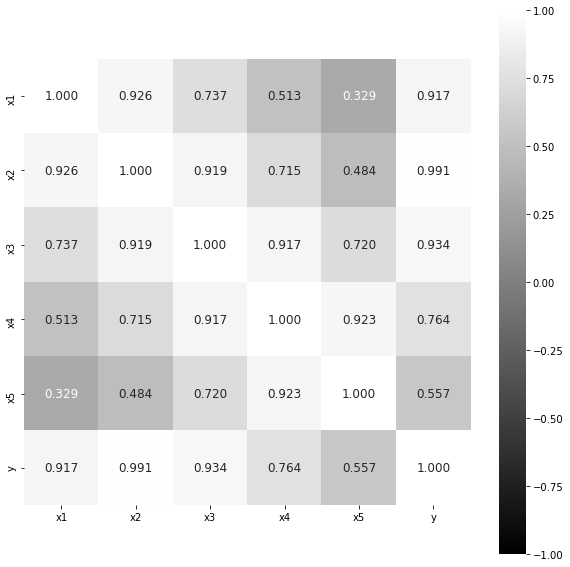

In [10]:
dfXcy = pd.DataFrame(np.hstack((Xtr_c, ytr_c)), columns=varNames)
dfCorrXc=dfXcy.corr() # correlation matrix

plt.figure(figsize = (10,10))
heatplt=sns.heatmap(dfCorrXc, annot=True, fmt=".3f", vmin=-1, vmax=1, cmap='gray', annot_kws={"size": 12},square=True);
cbar = heatplt.collections[0].colorbar
plt.show()

In [11]:
VIFc = np.diag(np.linalg.inv(dfCorrXc.to_numpy(copy=True)[:5,:5]))
print('Variance inflation factors: ', np.round(VIFc,3))

Variance inflation factors:  [  69.071  550.206 1003.514  583.892   73.421]


We observe that the estimated regression coefficients indeed do not reflect the true underlaying relationship (non-interpretable) in this case of sever multicollinearity, but the regression receives a similar $R^2$- and MSE-score, and thus does not suffer from the multicollinearity, as expected.

#### Conclusion on multicollinearity

In conclusion, multicollinearity leads to unreliable and unstable estimates of the regression coefficients (non-interpretable), but it does not affect the overall fit of the model or the predictions. We may deal with multicollinearity by e.g. removing one of two highly correlated inputs or combine the two inputs into one new (joint) input variable.

## Assumption 3: Additivity and linearity

This assumption relates to the linear regression model as being additive and linear in its predictors (including interactions), e.g. $y = w_0 + w_1 x_1 + w_2 x_2$. If additivity is violated, we may e.g. include interactions or transforms, and if linearity is violated, we may e.g. apply a transform(s) to the input(s). For example, $1/x$ or $log(x)$, Gelman et al. (2020, ch.11).

In our numerical toy example, the scatter matrix and the regression coefficients above (*Sample data* and *Ordinary least squares solution* section) tell a similar story, i.e. an apparent linear relationship between the output and the inputs $x_1$, $x_2$ and $x_4$ respectively. The scatter matrix by means of visualization and the regression coefficients by means of quantitative measures of dependence. Moreover, $R^2 \approx 1.0$ means that approximately $100\%$ of the variance in the original model outputs are captured by the linear regression model. As a rule of thumb, models for which $R^2 > 0.7$ are usually considered sufficient for the model to be representative of the data.

## Assumption 4: Independence of errors

This assumption relates to the white noise assumption of the error terms, i.e. the errors should not exhibit autocorrelation, an assumption that is violated in temporal, spatial, and multilevel settings, Gelman et al. (2020, ch.11).

### The independent case

Graphically, we can assess autocorrelation in the data series using the autocorrelation function;

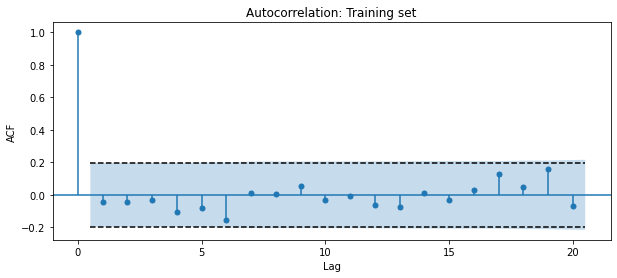

In [12]:
# see https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
mse_tr, ydiff_tr = myMSE(XXtr, ytr, Wols) # residual for training set
acf_bounds_theory = 1.96/np.sqrt(nXtr) # https://otexts.com/fpp2/wn.html
plt.figure(figsize=(10,4))
ax1=plt.subplot(1, 1, 1)
sm.graphics.tsa.plot_acf(ydiff_tr, ax=ax1, title='Autocorrelation: Training set');
plt.plot(np.array([0.5,20.5]), np.array([acf_bounds_theory, acf_bounds_theory]), '--k')
plt.plot(np.array([0.5,20.5]), np.array([-acf_bounds_theory, -acf_bounds_theory]), '--k')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show();

The plot includes the empirical and theoretical 95% confidence interval under a white noise assumption, i.e. the shaded region and the region enclosed by the dotted lines, respectively, see e.g. [wikipedia.org](https://en.wikipedia.org/wiki/Correlogram#Statistical_inference_with_correlograms). In this regard, correlation values outside the confidence bounds are very likely due to correlation and not due to random variation. As an exception, a realization is always perfectly correlated with itself, thus an autocorrelation of 1 is always observed at lag zero. In our plot, this is the only value outside the confidence bounds, which indicate that the independence of errors assumption is appropriate in this case.

Autocorrelation can also be tested by e.g. the Durbin-Watson test, where the null hypothesis is that there is no serial correlation in the data, see e.g. [www.statsmodels.org](https://www.statsmodels.org/stable/diagnostic.html) for more autocorrelation tests. For the Durbin-Watson test, the test statistic is

$$ \sum_{n=2}^N ( e[n]-e[n-1] )^2 {\big/} \sum_{n=1}^N ( e[n] )^2, $$

where $e[n]$ is the realized error for item $n$ in the data series. The test statistic is approximately equal to $2(1-r)$, where $r$ is the sample autocorrelation of the residuals. The test statistic is bounded between 0 and 4, with the midpoint 2 indication no autocorrelation. Values below 2 indicates a positive sample autocorrelation and values above 2 indicates a negative sample autocorrelation. Taking the theoretical bounds from before, we would expect a data series without serial correlation to fall in the range $2( 1 \pm 1.96 / \sqrt{N})$. This is the case for our data;

In [13]:
stat_dw = sm.stats.stattools.durbin_watson(ydiff_tr); print('Durbin-Watson test statistic: ', stat_dw)
bounds_dw = 2 * (1 + np.array([-1,1])*1.96/np.sqrt(nXtr)); print('95% confiden bounds: ', bounds_dw)

Durbin-Watson test statistic:  [2.08807684]
95% confiden bounds:  [1.608 2.392]


### Some dependent cases

For illustration purposes, some examples where the independence of errors assumption is violated are depicted below.

#### Moving average model of order 2 (MA(2))

In [14]:
# Simulate MA(2) process
np.random.seed(42)
z_autoEr = np.random.normal(loc=0, scale=1, size=1000); nZautoEr = len(z_autoEr)
ma2 = np.zeros([nZautoEr]) 
for i in np.arange(2,nZautoEr):
    ma2[i] = z_autoEr[i] + 0.7*z_autoEr[i-1] + 0.5*z_autoEr[i-2]

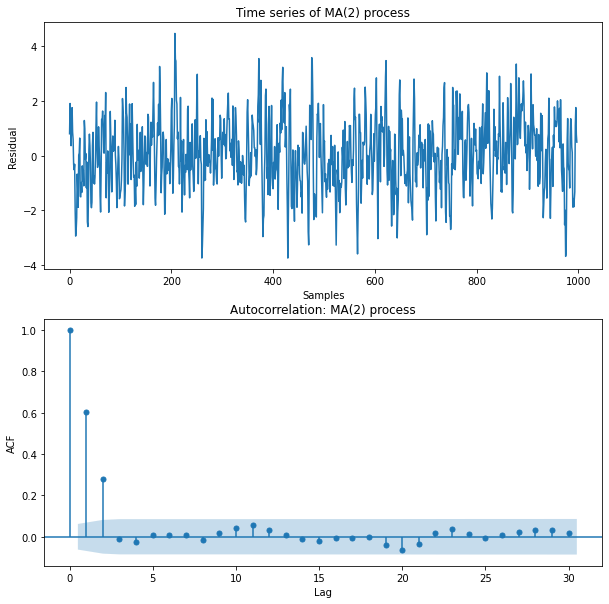

In [15]:
# Plot simulation results
plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)
plt.plot(ma2[2:])
plt.ylabel('Residual')
plt.xlabel('Samples')
plt.title('Time series of MA(2) process')

ax2=plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ma2[2:], ax=ax2, title='Autocorrelation: MA(2) process');
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show();

#### Autoregressive model of order 1 (AR(1))

In [16]:
# Simulate AR(1) process
ar2 = z_autoEr.copy();
for i in np.arange(1,nZautoEr):
    ar2[i] = 0.9*ar2[i-1] + z_autoEr[i]

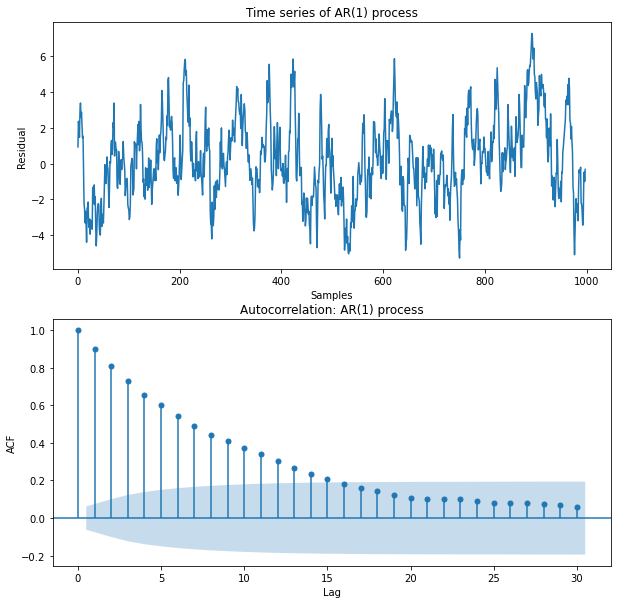

In [17]:
# Plot simulation results
plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)
plt.plot(ar2[2:])
plt.ylabel('Residual')
plt.xlabel('Samples')
plt.title('Time series of AR(1) process')

ax2=plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ar2[2:], ax=ax2, title='Autocorrelation: AR(1) process');
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show();

For the MA(2) and AR(1) above, we observe that the ACF plot exhibits different characteristics. Thus, for the MA(2) process, we see that the first two lags have a significant correlation for the values in the data series, which is consistent with the MA(2) generating process; for the AR(1) process, the correlation falls off gradually, which is a general characteristic of AR processes, when depicted using an ACF plot.

## Assumption 5: Equal variance of errors (homoscedasticity)

This assumption relates to the constant variance assumption of the noise term. If this is not the case, our model does not reflect the generative process of the data, and probabilistic predictions using the model would not be reliable. However, it does not affect the parametric model estimation, see Gelman et al. (2020, ch.11).

### The homoscedasticity case

A scatter plot of the residual values on the predicted values is one way of assessing the constant variance assumption. Thus, there should be no clear patterns in the residuals over the predicted values in the residual plot.

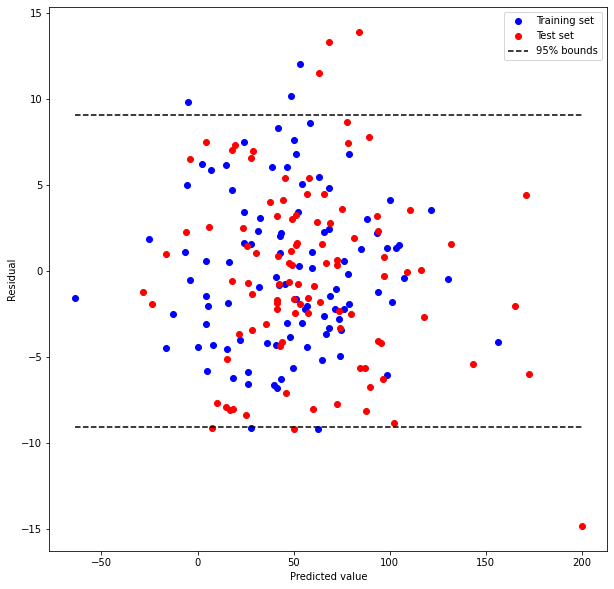

In [18]:
mu_pred_range_plot = np.array([np.min(np.concatenate([mu_pred_tr, mu_pred_te])), np.max(np.concatenate([mu_pred_tr, mu_pred_te]))])
plt.figure(figsize=(10, 10))
plt.plot(mu_pred_tr, ydiff_tr,'ob', label='Training set')
plt.plot(mu_pred_te, ydiff_te,'or', label='Test set')
plt.plot(mu_pred_range_plot, [1.96*sigma_ols_unbias]*2, '--k', label='95% bounds')
plt.plot(mu_pred_range_plot, [-1.96*sigma_ols_unbias]*2, '--k')
plt.ylabel('Residual')
plt.xlabel('Predicted value')
plt.legend()
plt.show()

From the residual plot, it appears that there are no clear patterns in the residuals over the predicted values in this example. 

Note that if we consider a plot of the residuals on the observed values, we cannot be sure not to see a pattern, as the model only assumes that the errors are independent of the inputs $\mathbf{x}[n]$ and not the output $y[n]$, see Gelman et al.(2020, ch.11). 

### Some heteroscedasticity cases

For illustration purposes, some examples where the constant variance assumption is violated are depicted below;

In [19]:
# Simulate heteroscedastic errors 
y_pred_hetEr = np.arange(-3,3,0.1); nYpred_autoEr= len(y_pred_hetEr)
y_res_hetEr_ex1 = (y_pred_hetEr**2).reshape(-1,1)*np.random.normal(loc=0,scale=1, size=(len(y_pred_hetEr),10)) # Ex1
y_res_hetEr_ex2 = np.exp(-np.linspace(0, 5, num=nYpred_autoEr)).reshape(-1,1)*np.random.normal(loc=0,scale=1, size=(nYpred_autoEr,10)) # Ex2

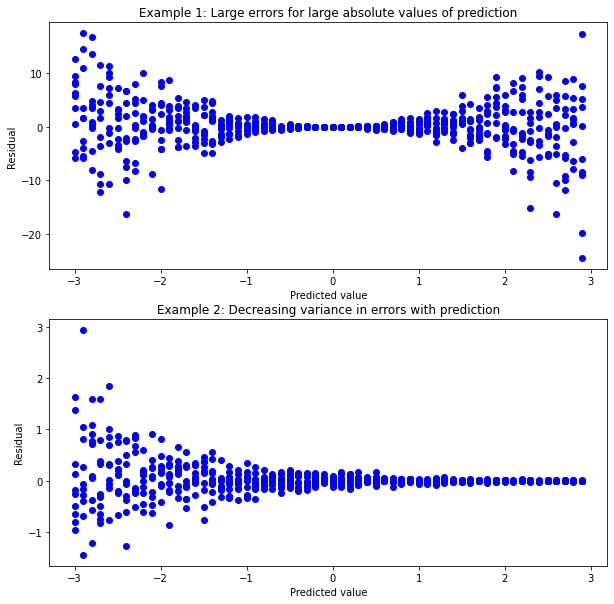

In [20]:
# Plot simulations
mu_pred_range_plot = np.array([np.min(np.concatenate([mu_pred_tr, mu_pred_te])), np.max(np.concatenate([mu_pred_tr, mu_pred_te]))])
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(y_pred_hetEr, y_res_hetEr_ex1,'ob')
plt.ylabel('Residual')
plt.xlabel('Predicted value')
plt.title('Example 1: Large errors for large absolute values of prediction')

plt.subplot(2,1,2)
plt.plot(y_pred_hetEr, y_res_hetEr_ex2,'ob')
plt.ylabel('Residual')
plt.xlabel('Predicted value')
plt.title('Example 2: Decreasing variance in errors with prediction')
plt.show()

## Assumption 6: Normality of errors

The distribution of errors is, as in the case of Assumption 5, mostly relevant for probabilistic predictions using the model, as it usually does not affect the parametric model estimation. Note that linear regression does not assume or require that inputs follow a Gaussian distribution, and the Gaussian assumption on the output refer to the error and not the raw data. Depending on the structure of the inputs, it is possible that data $\mathbf{y}$ does not conform with a normality assumption, but the regression errors do, see Gelman et al. (2020, ch.11).

In this tutorial, we will consider a set of graphical tools and statistical test (normality tests) for assessing whether a sample can be assumed to be drawn from a Gaussian distribution.

### Graphical tools

First, we consider scatter plots, histograms, and Q-Q plots for assessing normality.

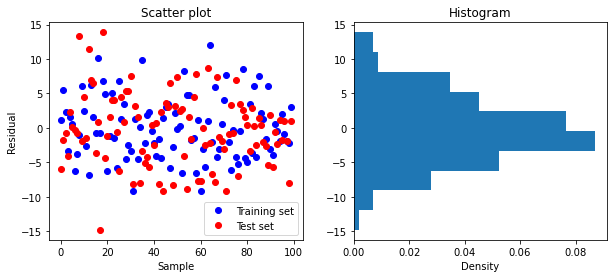

In [21]:
# residuals of both training and test set (used below for assessing normality)
ydiff = np.concatenate([ydiff_tr, ydiff_te]) 

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ydiff_tr,'ob', label='Training set')
plt.plot(ydiff_te,'or', label='Test set')
plt.ylabel('Residual')
plt.xlabel('Sample')
plt.title("Scatter plot")
plt.legend()

plt.subplot(1,2,2)
plt.hist(ydiff, density=True,orientation='horizontal')
plt.xlabel('Density')
plt.title("Histogram")
plt.show()

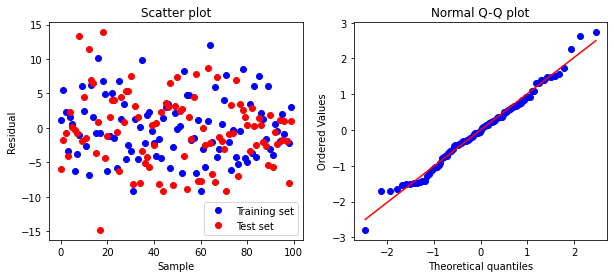

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ydiff_tr,'ob', label='Training set')
plt.plot(ydiff_te,'or', label='Test set')
plt.ylabel('Residual')
plt.xlabel('Sample')
plt.title("Scatter plot")
plt.legend()

plt.subplot(1,2,2)
ss.probplot(((ydiff_te-np.mean(ydiff_te))/np.std(ydiff_te)).reshape(-1), dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

From the scatter/histogram figure, we see that the data is centered around zero and has a Gaussian-like shape (bell-shape), where most of the probability mass is located around the mean.

From the scatter/Q-Q plot figure, we see that there are a few small deviations from the theoretical normal quantiles, especially in the lower and upper tail, which is to be expected given the small data sample.

### Normality tests

Next, we consider the Shapiro-Wilk test, D’Agostino’s K^2 test and Anderson-Darling test for assessing normality, see e.g. Wasserman (2004) for further details on hypothesis testing, and the ``SciPy`` documentation for details on the implementation of the test. 

Note that in the ``SciPy`` implementations used in this tutorial, we can interpret the $p$ value as follows:

- p > $\alpha$: we cannot reject $H_0$ (normal).
- p <= $\alpha$: we reject $H_0$ (not normal).

In [23]:
# see https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
stat_sha, p_sha = ss.shapiro(ydiff)
print('Statistics=%.3f, p=%.3f' % (stat_sha, p_sha))
# interpret
alpha = 0.05
if p_sha > alpha:
	print('We cannot reject H0 (normal)')
else:
	print('We reject H0 (not normal)')

Statistics=0.993, p=0.482
We cannot reject H0 (normal)


In [24]:
# see https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
stat_k2, p_k2 = ss.normaltest(ydiff)
print('Statistics=%.3f, p=%.3f' % (stat_k2, p_k2))
# interpret
alpha = 0.05
if p_k2 > alpha:
	print('We cannot reject H0 (normal)')
else:
	print('We reject H0 (not normal)')

Statistics=1.808, p=0.405
We cannot reject H0 (normal)


In [25]:
result_and = ss.anderson(ydiff.reshape(-1))
# print('Statistic: %.3f' % result_and.statistic)
p = 0
for i in range(len(result_and.critical_values)):
	sl, cv = result_and.significance_level[i], result_and.critical_values[i]
	if result_and.statistic < result_and.critical_values[i]:
		print('Significance level %.3f (critical value %.3f): We cannot reject H0 (normal)' % (sl, cv))
	else:
		print('Significance level %.3f (critical value %.3f): We reject H0 (not normal)' % (sl, cv))

Significance level 15.000 (critical value 0.565): We cannot reject H0 (normal)
Significance level 10.000 (critical value 0.644): We cannot reject H0 (normal)
Significance level 5.000 (critical value 0.772): We cannot reject H0 (normal)
Significance level 2.500 (critical value 0.901): We cannot reject H0 (normal)
Significance level 1.000 (critical value 1.071): We cannot reject H0 (normal)


In line with the graphical assessment, all the normality test indicate that we cannot reject a null-hypothesis of normality with a significance level of 5% (and lower). This is not always the case in practice, where there can be disagreement between the tests (and plots). Here engineering judgement comes into play, e.g. if the data looks normal and/or some of the normality test indicate that we cannot reject normality, maybe a Gaussian assumption is reasonable, or maybe we can transform the output variable to make it conform with a Gaussian assumption, see e.g. [machinelearningmastery.com](https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/).

# Interpretations of linear models

## Regression coefficients

The correct interpretation of a regression coefficient is the average difference in the outcome, when the corresponding input is changed by one unit, under the assumption of linearity in the inputs. Please note that this relates to population level inferences, whereas the causal interpretation of regression coefficients is the effect of fixing an input, and thus relates to inferences for individuals. To illustrate the difference in interpretation, consider the regression of earnings on years of education. On a population level, this related to the average difference in earnings, when the years of educations is increased by one year in the population. On an individual level, this relates to the effect on earnings for a single person, when increasing this persons years of education by one year, see Gelman et al.(2020, ch.11). 

## Sensitivity analysis

A well fitting linear regression model ($R^2 \geq 0.7$) also provides information regarding the output sensitivites in the inputs/factors, i.e. how much does the variance in input $x_i$ impact the variance in $y$, see my tutorial on [*Variance-based sensitivity analysis for independent inputs*](https://nbviewer.jupyter.org/github/SebastianGlavind/PhD-study/blob/master/Sensitivity-analysis/SA_varianceBased_independentInputs.ipynb) for more information.

The squared, standardized regression coefficients provides the means for what is typically refrerred to as factor prioritization in sensitivity analysis, i.e. the reduction in output variance, if an input set to its true value;

In [26]:
# Standardized regression coefficients acc. variance contribution
SRC = Wols * np.std(XXtr,0).reshape(-1,1) / np.std(ytr)
# Squared SRC
SRCsq = SRC**2;

print( 'Squared, standardized regression coefficients: ', np.round(SRCsq[range(1,6)],2).T, ', sum: ', np.round(np.sum(SRCsq[range(1,6)]),2) ) # almost the same as analytical values
print( 'R-squared for the linear regression model: ', np.round(Rsq,2) )

Squared, standardized regression coefficients:  [[0.04 0.91 0.   0.04 0.  ]] , sum:  1.0
R-squared for the linear regression model:  0.98


From the sensitivity indices above, it appears that $x_2$ is by far the one with the greatest impact on the $y$ and should be prioritized in relation to potential model refinements. We also observe an output variance contribution from $x_1$ and $x_4$ but not from $x_3$ and $x_5$, which is consistent with all findings above.